In [1]:
import sys 
sys.path.append('../../')
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import torch.nn.functional as F
import scipy
import pandas as pd
import os
import glob
import scienceplots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.style.use('science')
pd.set_option('display.float_format', lambda x: '%.4e' % x)
# import seaborn as sns
from dataset.generate_dataset_1d import poisson_kernel, logarithm_kernel
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.dataset import load_dataset_1d
from matplotlib import ticker
from matplotlib.text import Text

In [2]:
# process green's function
idx = 257
nh = 513
h = 1/(nh-1) # x in [-1, 1]
xh = torch.linspace(0,1,nh)
x_i = torch.cartesian_prod(xh, xh)#.reshape(nh,nh,2)
G = poisson_kernel(x_i[...,0], x_i[...,1], h)

# Green's function of Poisson 1D

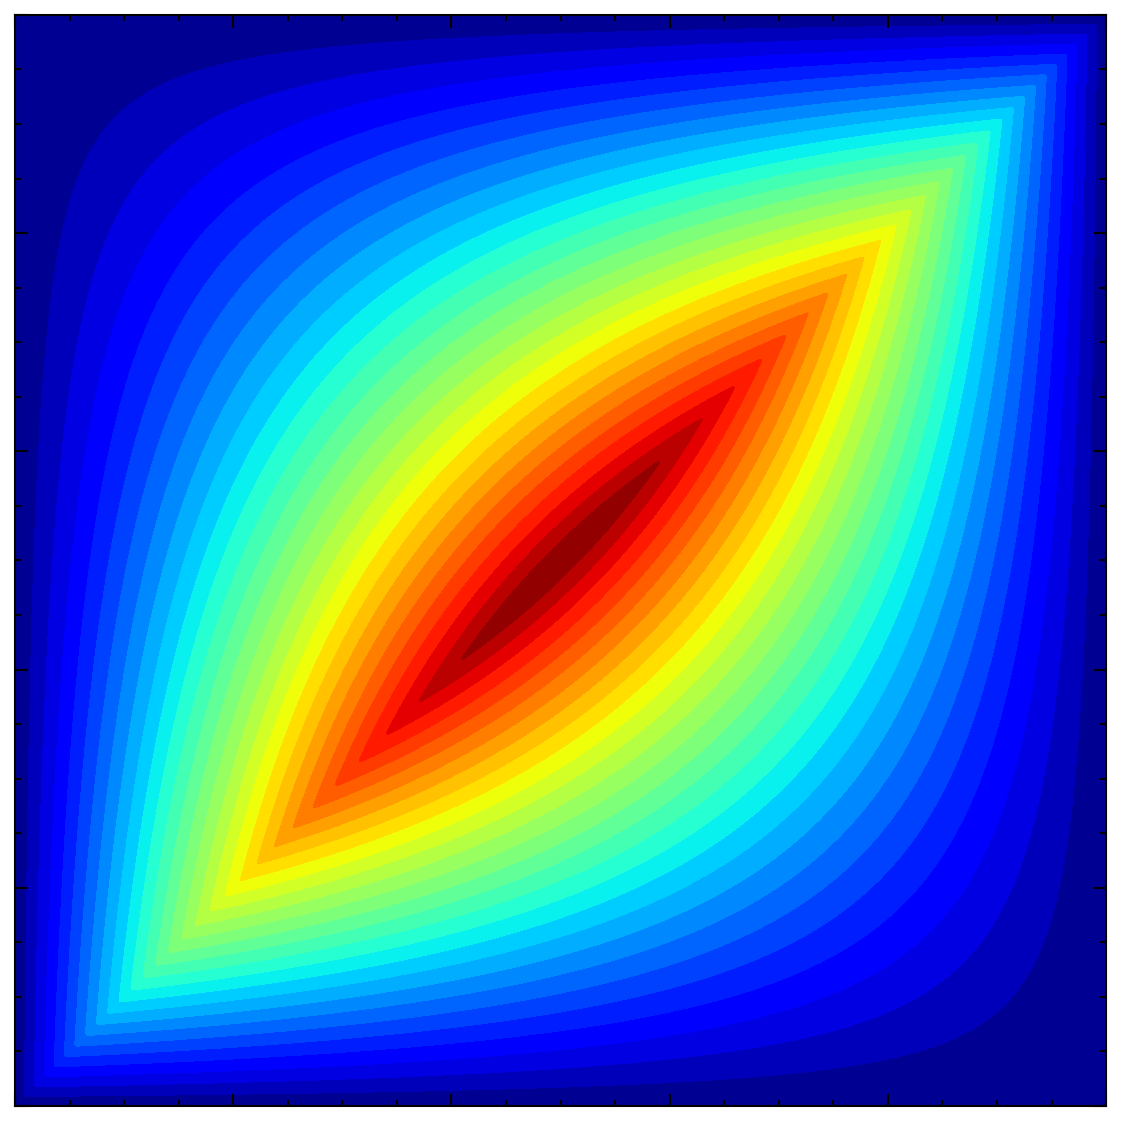

In [3]:
cm = 1/2.54
# visualize kernel slice
f = plt.figure(figsize=(10*cm,10*cm))
ax1 = f.add_subplot(111)

# visualize full kernel gn
levels =  np.linspace(0,0.25,30)
ax1.contourf(
    x_i[:,0].reshape(nh,nh), x_i[:,1].reshape(nh,nh),
    G.reshape(nh,nh), levels=levels, cmap='jet')
ax1.set_xticklabels([])
ax1.set_yticklabels([])

plt.tight_layout()
outnm = './poisson1d_green.png'
plt.savefig(outnm)

# Forcing func and Solution func

In [4]:
data_root = '/workdir/GreenMgNet/dataset'
train_loader, test_loader = load_dataset_1d(
    'poisson1d', data_root, bsz=1, res='513')

In [5]:
f, u = train_loader.dataset[0]

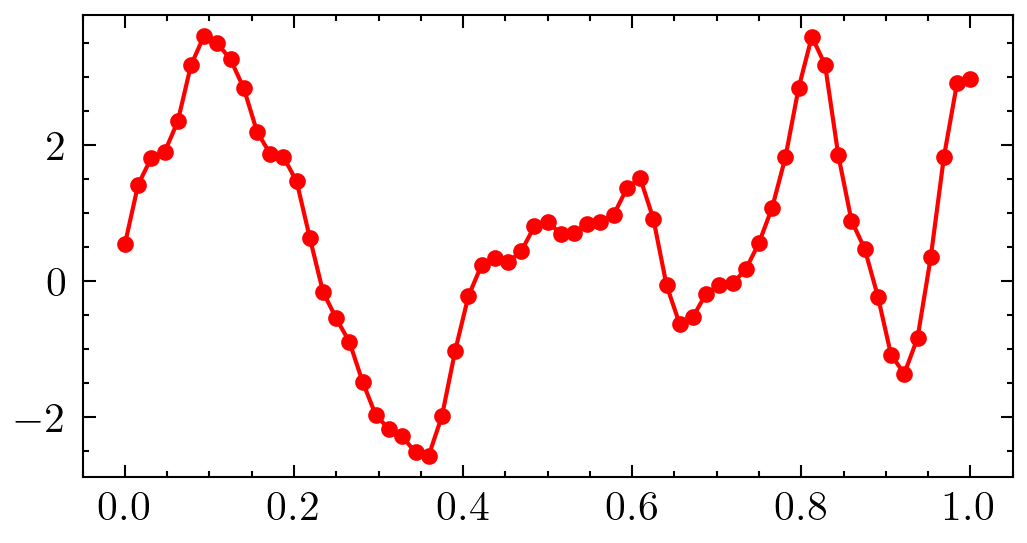

In [6]:
plt.figure(figsize=(4,2))
plt.plot(xh[::8], f.T[::8], '.-r')
outnm = './force1d.png'
plt.savefig(outnm)

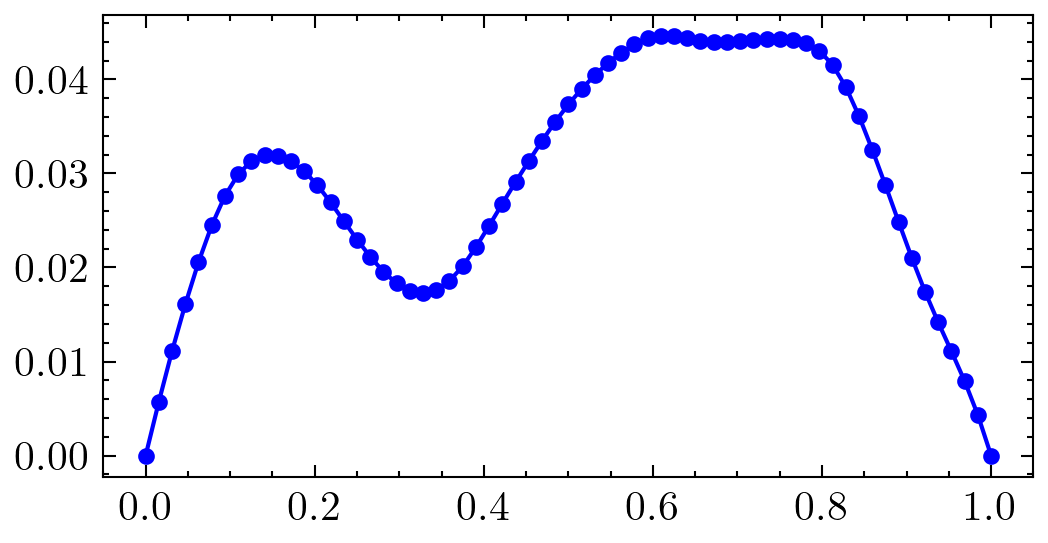

In [7]:
plt.figure(figsize=(4,2))
plt.plot(xh[::8], u.T[::8], '.-b')
outnm = './solution1d.png'
plt.savefig(outnm)

# Augmented neural network for kernel estimation

# 1D Poisson's Green's function with interface 

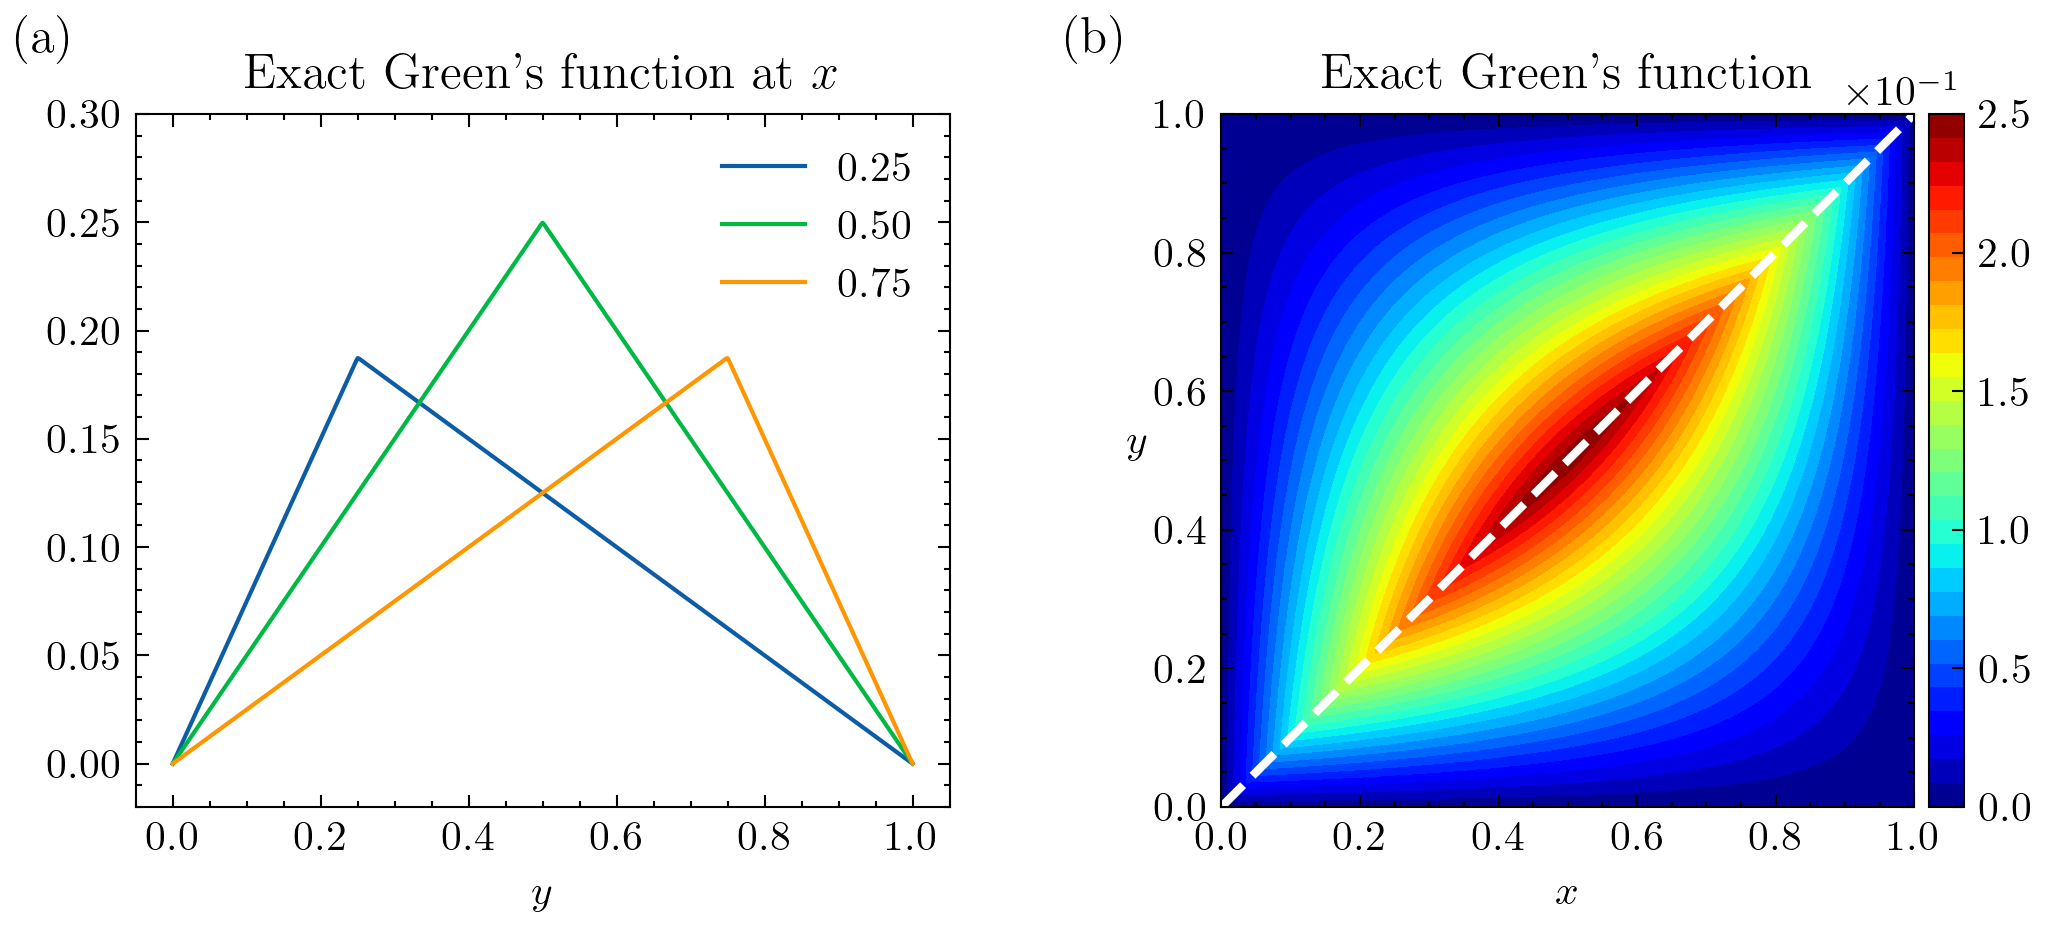

In [10]:
cm = 1/2.54
# visualize kernel slice
f = plt.figure(figsize=(7,3))

subfigs = f.subfigures(1,2).flatten()

ax1 = subfigs[0].subplots()
ax2 = subfigs[1].subplots()

# visualize kernel slice
ax1.plot(x_i[x_i[...,1]==0.25][:,0], G[x_i[...,1]==0.25], label='$0.25$')
ax1.plot(x_i[x_i[...,1]==0.5][:,0], G[x_i[...,1]==0.5], label='$0.50$')
ax1.plot(x_i[x_i[...,1]==0.75][:,0], G[x_i[...,1]==0.75], label='$0.75$')
ax1.set_ylim([-0.02, 0.3])
# ax1.set_xlim([-0., 1.1])
# ax1.set_aspect('equal')
ax1.legend(loc='upper right')
ax1.set_title('Exact Green\'s function at $x$')
# ax1.grid('on')
ax1.set_xlabel('$y$')
label_a = Text(0.01, 0.99, '(a)', fontsize=12, transform=subfigs[0].transSubfigure, ha="left", va="top")
subfigs[0].add_artist(label_a)

# visualize full kernel gn
im = ax2.contourf(
    x_i[:,0].reshape(nh,nh), x_i[:,1].reshape(nh,nh),
    G.reshape(nh,nh), levels=levels, cmap='jet')
ax2.plot(xh, xh, linestyle='dashed', color='w', linewidth=2)
ax2.set_aspect('equal')
ax2.set_title('Exact Green\'s function')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$', rotation=0)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(im, cax=cax, orientation='vertical')
cbar.locator = ticker.MaxNLocator(nbins=5)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
label_b = Text(0.01, 0.99, '(b)', fontsize=12, transform=subfigs[1].transSubfigure, ha="left", va="top")
subfigs[1].add_artist(label_b)

# plt.tight_layout()
outnm = './poisson1d_interface.pdf'
plt.savefig(outnm)

In [11]:
from src.ops import grid4d_coords

In [12]:
nh = 129
xh, _ = grid4d_coords(nh)
x1 = xh[:,0]
x2 = xh[:,1]
y1 = xh[:,2]
y2 = xh[:,3]
a = (x1-y1)**2+(x2-y2)**2
b = (x1*y2-x2*y1)**2+(x1*y1+x2*y2-1)**2
G = np.log(a/b)/(4*np.pi)
m1 = x1**2 + x2**2 > 1
m2 = (x1 == y1) & (x2 == y2)
G[m1] = np.nan
G[m2] = -1

/tmp/ipykernel_999245/2395545938.py:9: RuntimeWarning: divide by zero encountered in log
  G = np.log(a/b)/(4*np.pi)


In [13]:
G = G.reshape(nh,nh,nh,nh)

In [14]:
xh = np.linspace(-1,1,nh)
X, Y = np.meshgrid(xh, xh)#.reshape(nh,nh,2)
levels = np.linspace(-1., 0, 30)

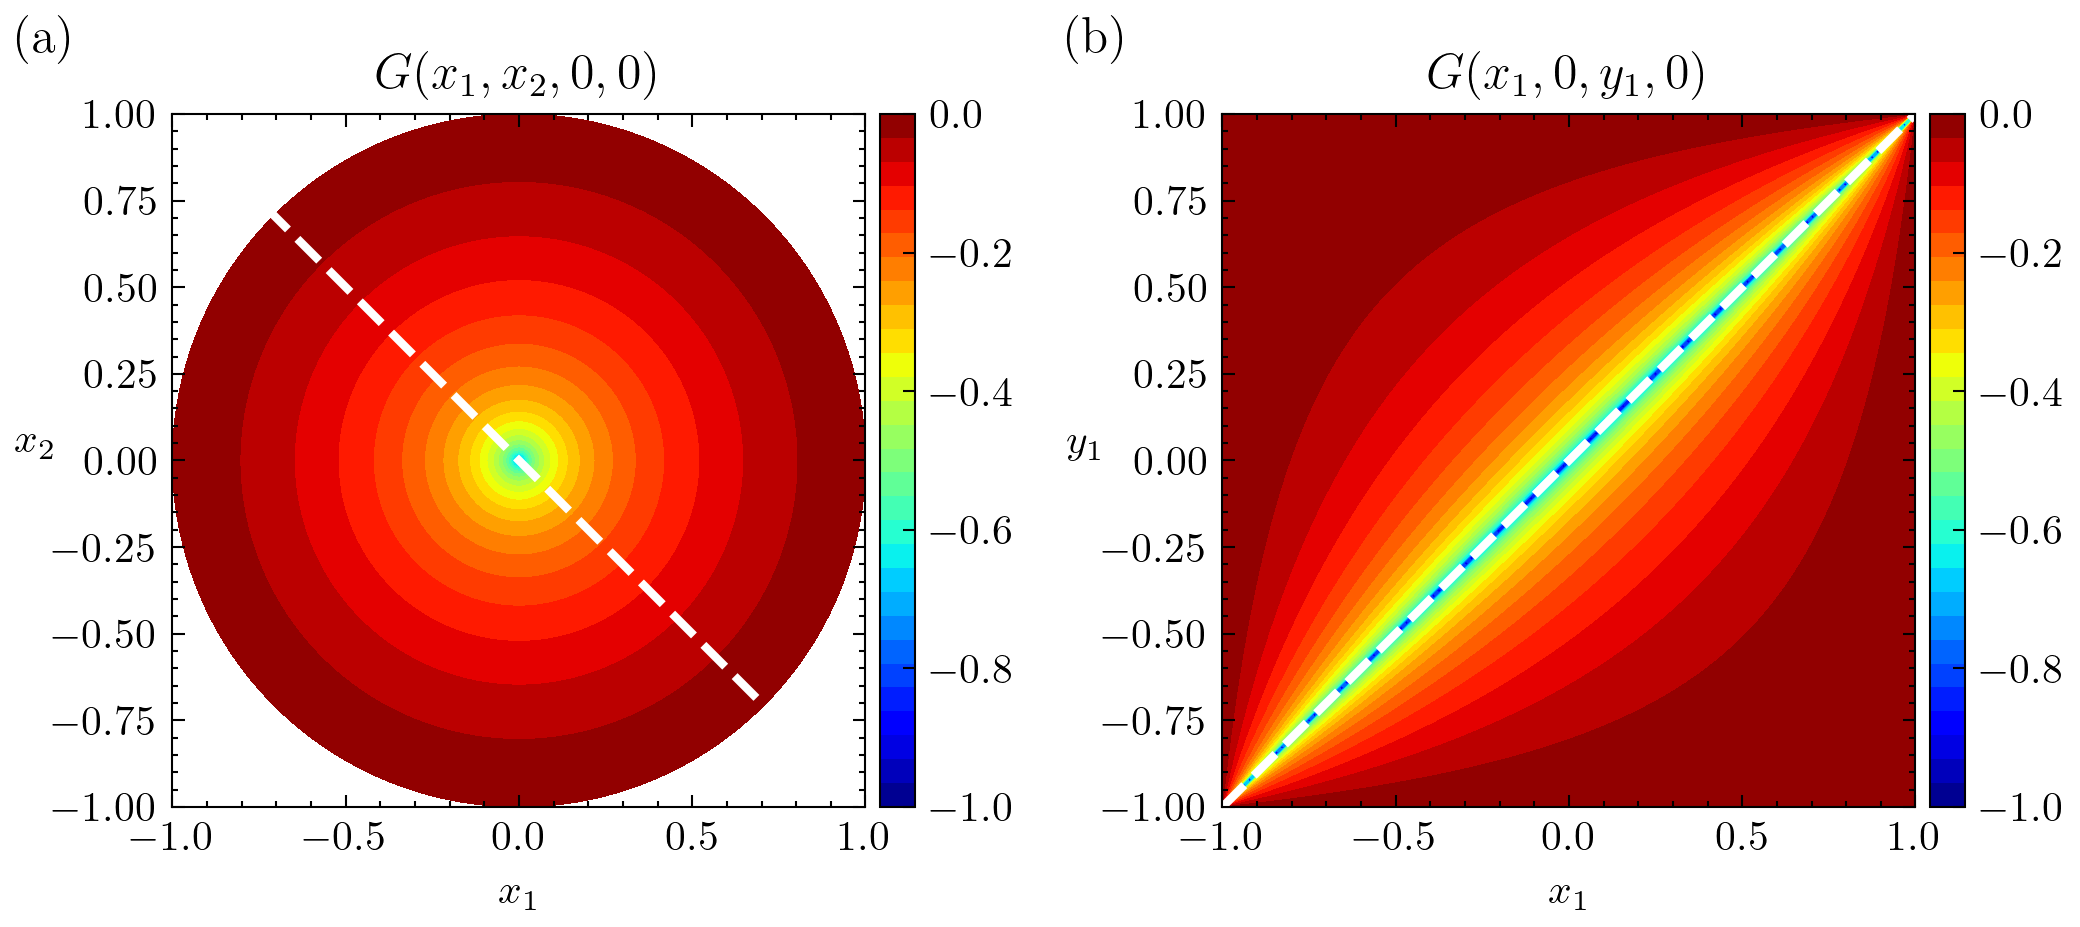

In [20]:
cm = 1/2.54
# visualize kernel slice
f = plt.figure(figsize=(7,3))

subfigs = f.subfigures(1,2).flatten()

ax1 = subfigs[0].subplots()
ax2 = subfigs[1].subplots()

# visualize kernel slice
im1 = ax1.contourf(
    X, Y, G[64,64], cmap='jet', levels=levels)
ax1.plot(
    x1[((x1-y1+x2-y2)==0) & (y1==0) & (y2==0)], 
    x2[((x1-y1+x2-y2)==0) & (y1==0) & (y2==0)], 
    linestyle='dashed', color='w', linewidth=2)
ax1.set_aspect('equal')
ax1.set_title('$G(x_1,x_2,0,0)$')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$', rotation=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(im1, cax=cax, orientation='vertical')
cbar.locator = ticker.MaxNLocator(nbins=5)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
label_a = Text(0.01, 0.99, '(a)', fontsize=12, transform=subfigs[0].transSubfigure, ha="left", va="top")
subfigs[0].add_artist(label_a)

# visualize full kernel gn
m2 = (x2==0) & (y2==0) & ((x1**2 + x2**2) <=1) & ((y1**2 + y2**2) <=1)
im2 = ax2.contourf(
    X, Y, G[:,64,:,64], cmap='jet', levels=levels)
ax2.plot(
    x1[((x1-y1+x2-y2)==0) & (x2==0) & (y2==0)], 
    y1[((x1-y1+x2-y2)==0) & (x2==0) & (y2==0)], 
    linestyle='dashed', color='w', linewidth=2)
ax2.set_aspect('equal')
ax2.set_title('$G(x_1,0,y_1,0)$')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$y_1$', rotation=0)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(im2, cax=cax, orientation='vertical')
cbar.locator = ticker.MaxNLocator(nbins=5)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
label_b = Text(0.01, 0.99, '(b)', fontsize=12, transform=subfigs[1].transSubfigure, ha="left", va="top")
subfigs[1].add_artist(label_b)

# plt.tight_layout()
outnm = './poisson2d_interface.pdf'

plt.savefig(outnm)